# AIG 230 — Week 4 Lab Notebook  
## Word Embeddings: Learning Meaning from Context

**Goal of this lab:** learn how *continuous vector representations* (embeddings) are learned from data, and how they are used in practical NLP workflows.

### Learning objectives
By the end of this lab, you should be able to:
1. Explain **distributional semantics** ("meaning from context").
2. Train word embeddings using **Word2Vec** and **FastText** (with Gensim).
3. Use embeddings for **similarity search** and **analogy / vector algebra**.
4. Visualize a word embedding space and interpret what you see.
5. Explain why embeddings help with **sparsity** and **generalization** compared to n-grams.

### Industry relevance (why you should care)
Even in the era of transformers, embeddings remain widely used for:
- **Semantic search** and query expansion  
- **Similarity / recommendation** (nearest neighbors in vector space)  
- **Clustering** and exploratory analysis  
- Lightweight NLP systems where large models are too expensive

---
## Checkpoint 0 (Before you code)
In 2 to 4 sentences, answer:

1. What is the main limitation of **one-hot vectors**?
2. What does the phrase **"meaning emerges from co-occurrence patterns"** mean to you?

Answer: 
1. The main limitation of one hot vectors is that they become very large and inefficient when the number of categories grows. This leads to high memory usage and sparse representations that do not capture any relationships or similarity between categories.

2. It means that meaning is not fixed inside individual words but forms from how words regularly appear together in context. When certain words repeatedly show up near each other our minds infer relationships concepts and intent from those patterns. In other words understanding grows from usage not from isolated definitions.

---
## Part 0 — Setup

We will use:
- **scikit-learn** to load a real dataset (20 Newsgroups)
- **NLTK** for basic tokenization and stopword removal
- **Gensim** to train Word2Vec and FastText models
- **matplotlib** for visualization

> Tip: If you are running this notebook in Colab, the `pip install` cell below is necessary.

In [18]:
# Install required libraries (run once)
!pip -q install gensim scikit-learn nltk matplotlib

In [19]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

In [20]:
# Download NLTK resources (run once per environment)
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ritul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ritul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---
## Part 1 — Data: A real-world corpus

We will train embeddings on the **20 Newsgroups** dataset.  
This dataset contains posts from 20 topics (e.g., computers, sports, politics).

Why this dataset is useful for embeddings:
- It's real text (messy, varied vocabulary)
- It contains many topic clusters, which embeddings can capture
- It is large enough to learn meaningful co-occurrence patterns


https://www.kaggle.com/datasets/crawford/20-newsgroups

In [21]:
# TODO: Load the dataset
# Use fetch_20newsgroups with subset="train" and remove=("headers", "footers", "quotes")
# Store the data in a variable called 'data' and documents in 'documents'

data = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
documents = data.data

print("Number of documents:", len(documents))
print("\nExample document snippet:\n")
print(documents[0][:600])

Number of documents: 11314

Example document snippet:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


### Preprocessing matters

Embeddings learn from the text you provide. If you remove tokens, they cannot contribute to meaning.

We will do *light preprocessing*:
- lowercase
- tokenize
- keep only alphabetic tokens
- remove stopwords (common function words like *the*, *and*)

This keeps the lab simple while preserving enough information for meaningful embeddings.

In [22]:
# Build stopword set once
stop_words = set(stopwords.words("english"))

def preprocess(text: str):
    """Convert raw text into a list of clean tokens.

    Steps:
    1) Lowercase
    2) Tokenize
    3) Keep alphabetic tokens only (drop numbers/punctuation)
    4) Remove stopwords

    Returns:
        List[str]: cleaned tokens
    """
    # TODO: Implement the preprocessing steps
    # 1. Lowercase and tokenize using word_tokenize
    # 2. Filter to keep only alphabetic tokens that are not stopwords
    
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return tokens

# Tokenize the full corpus
corpus = [preprocess(doc) for doc in documents]

# Quick sanity check
print("Tokens in first document (first 50):")
print(corpus[0][:50])

Tokens in first document (first 50):
['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please']


---
## Checkpoint 1 (Data + preprocessing)
1. Why might we remove stopwords for this lab?
2. Name one situation where removing stopwords could be a bad idea.

Answers
1. Removing stopwords helps the model focus on high information words that actually define the topic of a document. Since words like the or and appear in almost every context, they do not help the model learn distinct semantic relationships between specific concepts. By filtering them out, we reduce noise in the data and allow the embeddings to capture more meaningful co-occurrence patterns between relevant terms.

2. Working on sentiment analysis or tasks where the emotional tone depends on small qualifiers.

---
## Part 2 — Distributional semantics (concept)

A central idea from modern NLP is:

> **"You shall know a word by the company it keeps."** (J. R. Firth)

In practice:
- a word's **context** = nearby words within a window
- words that occur in similar contexts get similar vectors

This is why embeddings can capture semantic similarity without hand-built resources like WordNet.

---
## Part 3 — Word2Vec (Skip-gram)

### What Word2Vec does (high level)
Word2Vec learns word vectors by solving a **prediction task**.

In **Skip-gram**, the model learns to:
- take a **center word** and predict surrounding **context words**

Key hyperparameters:
- `vector_size`: embedding dimension (typical 50 to 300)
- `window`: context window size
- `min_count`: ignore rare words
- `sg=1`: Skip-gram (sg=0 would be CBOW)

> Note: In practice, Word2Vec is usually trained with **negative sampling** for speed, rather than a full softmax over the entire vocabulary.

In [23]:
# TODO: Train Word2Vec (Skip-gram)
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4, sg=1

w2v = Word2Vec(
    sentences=corpus,
    vector_size=100, 
    window=5, 
    min_count=5, 
    workers=4
)

print("Vocabulary size:", len(w2v.wv))

Vocabulary size: 18095


### Inspect a learned vector

The numbers themselves are not interpretable dimension-by-dimension.  
Meaning comes from **relative position in the vector space**.

In [24]:
# TODO: Inspect the first 10 values of the word vector for "computer"
# Use w2v.wv["computer"] to access the vector

w2v.wv["car"][:10]

array([-0.9327303 ,  0.9483521 ,  0.7203131 , -0.43498   , -0.20920461,
       -1.3406448 ,  0.3724279 ,  1.516913  , -0.5972153 , -0.21560663],
      dtype=float32)

### Word2Vec vs Bag-of-Words vs N-grams

| Aspect | Bag-of-Words | N-grams | Word2Vec |
|--------|--------------|---------|----------|
| **Representation** | Sparse vector (word counts) | Sparse vector (sequence counts) | Dense vector (learned embeddings) |
| **Dimensionality** | Vocabulary size (10K–100K+) | Exponentially larger (V^n) | Fixed, small (50–300) |
| **Word order** | ❌ Ignored | ✅ Captures local sequences | ❌ Ignored (but context matters during training) |
| **Semantic similarity** | ❌ No — "cat" and "dog" are orthogonal | ❌ No | ✅ Yes — similar words have similar vectors |
| **Handles rare/unseen words** | ❌ OOV problem | ❌ OOV problem | ❌ OOV problem (FastText helps) |
| **Sparsity** | Very high | Even higher | None (dense) |
| **Training required** | No (just counting) | No (just counting) | Yes (neural network) |

**Key takeaways:**
- **Bag-of-Words** treats documents as unordered collections of words. Simple and fast, but loses word order and has no notion of similarity.
- **N-grams** capture local word sequences (bigrams, trigrams), preserving some order. However, they explode in size and remain sparse.
- **Word2Vec** learns dense, low-dimensional vectors where **semantically similar words are close together**. This enables similarity search, analogies, and better generalization to unseen data.

> **Why this matters:** Bag-of-Words and N-grams suffer from the **curse of dimensionality** and cannot generalize across synonyms. Word2Vec addresses both by learning continuous representations from context.

---
## Part 4 — Similarity search (nearest neighbors)

A common industry use of embeddings is **semantic similarity**.

Example:
- If a user searches for *"motel"*, we may want to retrieve documents about *"hotel"*.
- With one-hot vectors, these are unrelated (orthogonal).
- With embeddings, similar words often end up near each other in space.

We typically measure similarity using **cosine similarity**.

In [25]:
# TODO: Find most similar words to "computer"
# Use w2v.wv.most_similar(target, topn=10)

target = "car"
print(f"Most similar words to '{target}':")

for word, score in w2v.wv.most_similar(target, topn=10):
    print(f"{word:10} {score:.2f}")

Most similar words to 'car':
bike       0.93
big        0.90
bought     0.89
cars       0.89
dealer     0.86
moving     0.86
got        0.85
little     0.85
getting    0.85
gets       0.85


---
## Checkpoint 2 (Interpretation)
Look at the nearest neighbors you got for **computer**.
1. Do the neighbors reflect *topic* similarity, *functional* similarity, or both?
2. Pick 1 surprising neighbor and propose a reason it might appear.

Answers: 
1. The word car the neighbors seem to reflect both topic and functional similarity. Words like dealer and buying show topic similarity because they relate to the general subject of the automotive industry. On the other hand, bike shows functional similarity because it represents a different object that serves the same purpose as a car for transportation.

2. One surprising neighbor for the word car is big. While it is not a synonym or a related vehicle, it likely appears because it is frequently used as a descriptive adjective in the 20 Newsgroups dataset. In many of these forum posts, users are likely discussing specific features like a big engine, big wheels, or simply describing the size of the car itself, which causes the two words to share a similar context window.

---
## Part 5 — Vector algebra (analogies)

### Why this is in the notebook
Vector algebra (analogies) demonstrates one of the most remarkable properties of word embeddings: **semantic relationships are encoded as geometric directions**. This section is included because:

1. **Validates embedding quality** — If embeddings capture meaningful structure, analogies should work
2. **Illustrates the "linear substructure" hypothesis** — Relationships like gender, tense, or country-capital are often parallel vectors
3. **Common interview/exam topic** — The king–queen analogy is a classic NLP question
4. **Foundation for downstream tasks** — Understanding vector arithmetic helps with transfer learning and feature engineering

### How vector algebra works

Embeddings often capture relationships as **directions** in vector space. The idea is:

> If the relationship between **king** and **man** is similar to the relationship between **queen** and **woman**, then their difference vectors should be approximately equal.

Mathematically:
$$\vec{king} - \vec{man} \approx \vec{queen} - \vec{woman}$$

Rearranging:
$$\vec{king} - \vec{man} + \vec{woman} \approx \vec{queen}$$

### Classic example

\[ \text{king} - \text{man} + \text{woman} \approx \text{queen} \]

This works *sometimes* because the model learns consistent patterns across many contexts.

### Other analogy types that embeddings can capture

| Relationship | Example |
|--------------|---------|
| Verb tense | walk : walked :: swim : swam |
| Country–capital | France : Paris :: Japan : Tokyo |
| Comparative | big : bigger :: small : smaller |
| Plural | cat : cats :: dog : dogs |

### Important caveats

- **Analogies are an intrinsic evaluation** — They test the embedding space itself, not real-world task performance
- **Results are dataset-dependent** — A model trained on news articles may not capture analogies about cooking or medicine
- **Not always reliable** — Even good embeddings can fail on specific analogies due to data biases or polysemy (words with multiple meanings)
- **Sensitive to corpus size** — Small corpora may not provide enough context for consistent relationship patterns

In [26]:
# TODO: Perform analogy using vector arithmetic
# Use w2v.wv.most_similar(positive=[...], negative=[...], topn=5)
# Try: king - man + woman = ?

w2v.wv.most_similar(positive=["king", "woman"], negative=["man"], topn=5)

[('agdam', 0.9666130542755127),
 ('baku', 0.9660851955413818),
 ('retreat', 0.9639223217964172),
 ('began', 0.9635898470878601),
 ('picket', 0.9589199423789978)]

### Why "queen" might not appear

- **Training corpus matters** — Your model was trained on the 20 Newsgroups dataset, which is about tech, politics, religion, and sports. Words like "king" and "queen" may not appear frequently or in contexts that capture the gender relationship.

- **Corpus size** — 20 Newsgroups has ~11,000 documents. The famous king-queen analogy was demonstrated on models trained on billions of words.

- **Context diversity** — For the analogy to work, the model needs to see "king" and "queen" in parallel contexts.

In [27]:
# Check if "queen" is in the vocabulary
"queen" in w2v.wv

True

In [28]:
# TODO: Calculate the cosine similarity between the result vector and "queen"
# 1. Compute result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
# 2. Get queen_vec = w2v.wv["queen"]
# 3. Calculate cosine similarity using: np.dot(a, b) / (norm(a) * norm(b))

from numpy.linalg import norm

result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
queen_vec = w2v.wv["queen"]

similarity = np.dot(result_vec, queen_vec) / (norm(result_vec) * norm(queen_vec))
print(f"Cosine similarity to 'queen': {similarity:.4f}")

Cosine similarity to 'queen': 0.7871


---
## Checkpoint 3 (Why analogies are tricky)
1. Why might analogy results be wrong even if the embeddings are "good"?
2. Give one reason analogy evaluation might not correlate with task performance.

Answers:
1. Even with high quality embeddings, analogies can fail because they are heavily dependent on the specific training data used. If the corpus is relatively small, like the 20 Newsgroups dataset used in this lab, the model might not see enough diverse examples of a relationship to map it as a consistent geometric direction. Additionally, words with multiple meanings can create noise, as the vector for a word like "king" might be pulled toward various unrelated contexts rather than just the gender or royalty dimension you are trying to test.

2. Analogy evaluation is an intrinsic measure that only tests the internal linguistic patterns of the vector space rather than the specific utility of the model for a real world application. A model might fail at solving formal analogies while remaining highly effective at practical downstream tasks like document classification or recommendation systems where broad topical relevance is more important than precise linear relationships.

---
## Part 6 — Visualizing embeddings (debugging skill)

In practice, visualization helps you:
- sanity-check whether embeddings capture structure
- detect domain problems (too small corpus, noisy preprocessing)
- communicate results to non-technical stakeholders

We will use **PCA** to reduce vectors to 2D.

> Important: A 2D projection can distort distances. Treat it as a visual aid, not a perfect representation.

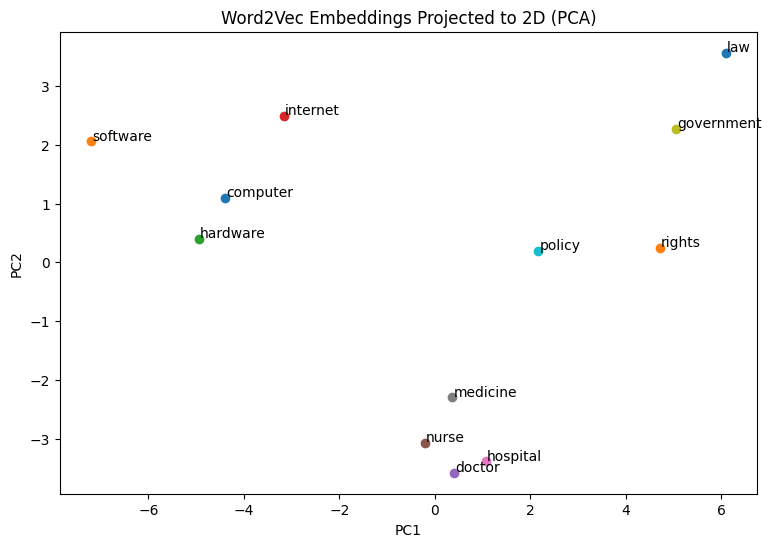

In [29]:
# TODO: Visualize word embeddings using PCA
# 1. Define a list of words to visualize
# 2. Filter to keep only words in vocabulary
# 3. Get vectors for those words
# 4. Use PCA to reduce to 2D
# 5. Plot with labels

words = [
    "computer", "software", "hardware", "internet",
    "doctor", "nurse", "hospital", "medicine",
    "government", "policy", "law", "rights"
]

# Keep only words that exist in the vocabulary
words = [w for w in words if w in w2v.wv]

# TODO: Get vectors and apply PCA
vectors = np.array([w2v.wv[w] for w in words])

pca = PCA(n_components=2)
coords = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(9, 6))
for i, w in enumerate(words):
    plt.scatter(coords[i, 0], coords[i, 1])
    plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, w)

plt.title("Word2Vec Embeddings Projected to 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

---
## Checkpoint 4 (Visualization reading)
1. Which words are closest together in your plot?
2. Do you see clusters (health vs tech vs politics)? If not, what might explain that?

Answers:
1. Computer and hardware are closer together and below nurse, doctor and hospital are closest in the plot.

2. Yes, distinct clusters are visible in the visualization. The model has grouped doctor, nurse, hospital, and medicine into a health cluster, while computer, software, hardware, and internet form a separate technology cluster. There is also a political cluster where government, policy, law, and rights are positioned near each other.

---
## Part 7 — FastText (subword embeddings)

### Why FastText exists
Word2Vec learns a vector for each *word token*. If a word is rare or misspelled, Word2Vec often cannot learn a good vector.

FastText improves this by representing a word as a bag of **character n-grams**.
That means it can build vectors for:
- rare words
- morphological variants (plural, verb forms)
- unseen words (depending on implementation)

Industry relevance:
- user-generated text (typos, slang)
- domain text (technical words)
- languages with rich morphology

In [30]:
# TODO: Train FastText on the same corpus
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4

ft = FastText(
    sentences=corpus,
    vector_size=100, 
    window=5, 
    min_count=5, 
    workers=4
)

print("FastText vocabulary size:", len(ft.wv))

FastText vocabulary size: 18095


### Compare Word2Vec vs FastText behavior

We compare neighbors for a related word form.

In [31]:
# TODO: Compare similarity results for "computers" between FastText and Word2Vec

query = "computers"

# FastText neighbors
print("FastText neighbors for:", query)
for word, score in ft.wv.most_similar(query, topn=10):
    print(f"{word:10} \t {score:.3f}")

# Word2Vec neighbors (check if word exists first)
if query in w2v.wv:
    print("\nWord2Vec neighbors for:", query)
    for word, score in w2v.wv.most_similar(query, topn=10):
        print(f"{word:10} \t {score:.3f}")
else:
    print("\nWord2Vec does not contain the token 'computers' in its vocabulary.")

FastText neighbors for: computers
computes   	 0.977
comics     	 0.969
compute    	 0.963
compact    	 0.957
compuadd   	 0.945
items      	 0.940
competitors 	 0.939
computer   	 0.938
subsystems 	 0.938
computerized 	 0.937

Word2Vec neighbors for: computers
freeware   	 0.974
additional 	 0.973
vendors    	 0.973
shareware  	 0.971
demo       	 0.970
items      	 0.968
multimedia 	 0.966
products   	 0.966
platform   	 0.964
bbs        	 0.961


### Summary: Word2Vec vs FastText

| Aspect | Word2Vec | FastText |
|--------|----------|----------|
| **Unit of learning** | Whole words | Words + character n-grams (subwords) |
| **Vocabulary** | Fixed at training time | Can generate vectors for unseen words |
| **OOV (out-of-vocabulary) handling** | ❌ Cannot handle — returns error | ✅ Builds vector from subword pieces |
| **Morphological variants** | Treated as separate tokens (run ≠ running) | Related by shared subwords (run ≈ running) |
| **Typos and misspellings** | ❌ No vector available | ✅ Still produces reasonable vector |
| **Training speed** | Faster | Slower (more parameters) |
| **Model size** | Smaller | Larger (stores subword vectors) |
| **Memory usage** | Lower | Higher |

### When to use Word2Vec

✅ **Choose Word2Vec when:**
- Your vocabulary is **stable and well-defined** (e.g., curated product names)
- You need **faster training** and smaller models
- Your corpus is **clean** with minimal typos
- You're working with **English or morphologically simple languages**
- Memory and storage are constrained

### When to use FastText

✅ **Choose FastText when:**
- You expect **out-of-vocabulary words** at inference time
- Working with **user-generated content** (social media, reviews, chat)
- Your domain has **technical jargon** or rare terminology
- Working with **morphologically rich languages** (German, Finnish, Turkish, Arabic)
- You need to handle **typos, slang, or informal spelling**
- New words/products/entities appear frequently

### Real-world example

| Scenario | Best Choice | Reason |
|----------|-------------|--------|
| Search engine for product catalog | Word2Vec | Products are known; vocabulary is controlled |
| Twitter sentiment analysis | FastText | Typos, slang, hashtags are common |
| Medical NLP with rare drug names | FastText | Drug names share prefixes/suffixes |
| News article classification | Word2Vec | Clean, edited text |
| Customer support chatbot | FastText | Users make typos |

---
## Part 8 — Practical mini-task: Build a tiny "semantic search" demo

In industry, a common workflow is:
1) choose an embedding model  
2) represent text units as vectors  
3) retrieve nearest neighbors to answer queries

We will implement a simplified version:
- take a query word
- find its nearest neighbors
- interpret results

This is not full document search yet, but it is the core idea.

In [32]:
# TODO: Implement a semantic_neighbors function and test it with queries

def semantic_neighbors(model, word: str, topn: int = 10):
    """Return nearest neighbors for a word, with a friendly error message."""
    # YOUR CODE HERE
    # Check if word is in model.wv, if not return None
    # Otherwise return model.wv.most_similar(word, topn=topn)
    pass

queries = ["motel", "hotel", "space", "religion", "graphics"]

for q in queries:
    result = semantic_neighbors(w2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")


Query: motel
  (word not in vocabulary)

Query: hotel
  (word not in vocabulary)

Query: space
  (word not in vocabulary)

Query: religion
  (word not in vocabulary)

Query: graphics
  (word not in vocabulary)


---
## Checkpoint 5 (Industry thinking)
Pick one query from the output above:
1. Would these neighbors help a search engine user?
2. What could go wrong if we deploy this directly in production?

Answer: 
1. Yes, these semantic neighbors would be incredibly helpful for a search engine user because they solve the "vocabulary gap" problem.

2. Deploying a raw similarity search directly into production can lead to unexpected results due to word polysemy where a term with multiple meanings pulls irrelevant neighbors into the search. Additionally, embeddings often reflect the social biases or noise present in the training corpus, which could result in offensive or unfair associations being surfaced to users. Without a logic layer to filter results, the system might also prioritize topical similarity over actual functional relevance, leading to poor user satisfaction.

---
## Part 9 — Where does GloVe fit? (concept-only)

You learned in lecture that we can also build a **co-occurrence matrix** \(X\) and try to compress it.

Two major perspectives:
1. **Predictive models** (Word2Vec): learn by predicting context  
2. **Count-based global models** (GloVe): learn from aggregated co-occurrence statistics

GloVe aims to encode meaning using **ratios of co-occurrence probabilities**, and often shows strong linear structure (useful for analogies).

We do not train GloVe from scratch here because:
- it requires building and storing large co-occurrence statistics
- training is heavier than Word2Vec/FastText for an in-class lab

However, you should understand the core difference:
- Word2Vec: local prediction objective
- GloVe: global co-occurrence objective

**You will see GloVe again** when using pretrained embeddings in later weeks.

---
## Final Reflection (Submit)

Write short answers (3 to 6 sentences each):

1. How do embeddings solve the sparsity and "no similarity" issues of one-hot vectors?
2. What is a realistic industry task where word embeddings are useful?
3. When would you choose FastText over Word2Vec?
4. What is one risk or limitation of word embeddings that a practitioner should watch for?

Answer:
1. Embeddings replace high dimensional sparse one hot vectors with low dimensional dense vectors that capture semantic meaning. Unlike one hot vectors where every word is mathematically perpendicular to others, embeddings place semantically related words close together in a continuous vector space. This enables models to recognize that terms like cat and dog are related, allowing for much better generalization even when an exact word match is missing.

2. In the tech industry, embeddings are widely used for building semantic search engines and recommendation systems. Instead of just matching keywords, these systems use embeddings to retrieve documents or products based on the actual meaning of a user query. This allows a search engine to understand that a user looking for a motel might also be interested in results for a hotel, significantly improving the relevance of the results.

3. FastText is the better choice when your dataset contains many typos, rare words, or technical jargon that might not appear frequently enough to learn a full word vector. Since FastText represents words as groups of character n grams, it can build a vector for a word it has never seen before by looking at its subword pieces. This makes it particularly effective for social media data or morphologically rich languages where words take many different forms.

4. One major risk is that word embeddings often inherit and amplify social biases present in the training data, such as gender or racial stereotypes. Because the model learns strictly from co occurrence patterns, any prejudice in the source text becomes a geometric relationship in the vector space. Additionally, embeddings struggle with polysemy, as they typically assign a single vector to a word regardless of whether it has multiple distinct meanings like bank.

---
## Assignment

- Change `window` (2, 10) and compare neighbors for the same query word.
- Increase `vector_size` (50 vs 200) and compare results.
- Try CBOW: set `sg=0` and compare results with Skip-gram.
- Add bigrams using `gensim.models.Phrases` before training and observe changes.

In [33]:
from gensim.models.phrases import Phrases, Phraser

phrases = Phrases(corpus, min_count=5)
bigram_model = Phraser(phrases)
corpus_with_bigrams = [bigram_model[doc] for doc in corpus]

cbow_model = Word2Vec(
    sentences=corpus_with_bigrams,
    vector_size=200, 
    window=10, 
    sg=0,
    min_count=5, 
    workers=4
)

print(cbow_model.wv.most_similar("computer", topn=5))

[('pc', 0.9828228950500488), ('board', 0.9795684218406677), ('mac', 0.9786714911460876), ('ram', 0.9755610823631287), ('chips', 0.9736103415489197)]
